In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import aptwrapper
import numpy as np
import pandas as pd

In [2]:
images = pickle.load(open("./cache/maps_aligned_processed.pkl", "rb"))
# images = {k: v for k, v in images.items() if v.experiment.item() == 'recovery_timeline'}
ibtable = pickle.load(open("./cache/ibtable.pkl", "rb"))

# IB anatomy

In [3]:
from matplotlib.patches import bbox_artist
from skimage.morphology import binary_erosion, disk, square
from scipy.ndimage import center_of_mass
from skimage.morphology import binary_dilation

def d2edge(mask: np.ndarray):
    dilution_factor = 2
    mask = binary_dilation(mask, square(2*dilution_factor + 1))
    original_mask = np.copy(mask)
    distances = np.zeros_like(mask, dtype=int)
    i = -dilution_factor

    while mask.any():
        distances[mask] = i
        i += 1
        mask = binary_erosion(mask, square(3))

    return np.where(original_mask, distances, np.nan)

# Make a dataframe of every pixel with its distance to edge, beta ratio, and PLL
df_ibanatomy = pd.concat(
    [pd.DataFrame(dict(
        d2e = d2edge(im.ib_labels.data).flatten(),
        pll = im.pll.data.flatten(),
        beta_ratio = (im.amp1625/im.amp1650).data.flatten(),
        is_epoxy = ~im.cell_labels.data.flatten().astype(bool),
        cell_label = im.cell_labels.data.flatten(),
        ib_label = im.ib_labels.data.flatten(),
        series = im.series.item(),
        condition = im.condition.item(),
        replicate = im.replicate.item(),
    )) for im in images.values()]
)

df_ibanatomy = df_ibanatomy.assign(
    ib_id   = df_ibanatomy.series + '-' + df_ibanatomy.condition + '-' + df_ibanatomy.replicate + '-' + df_ibanatomy.ib_label.astype(str),
    cell_id = df_ibanatomy.series + '-' + df_ibanatomy.condition + '-' + df_ibanatomy.replicate + '-' + df_ibanatomy.cell_label.astype(str),
)

# Normalise beta ratio to mean of each cell
df_ibanatomy = df_ibanatomy.groupby(['series', 'condition', 'replicate', 'cell_label'], group_keys=False).apply(lambda x: x.assign(beta_ratio=x.beta_ratio/x.beta_ratio.mean()))
df_ibanatomy = df_ibanatomy.dropna(subset='d2e').reset_index()
df_ibanatomy = df_ibanatomy.query('not is_epoxy')

# df

/var/folders/m4/tld763w57mz1njb87w177rlrhl_dmw/T/ipykernel_63226/673363003.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ibanatomy = df_ibanatomy.groupby(['series', 'condition', 'replicate', 'cell_label'], group_keys=False).apply(lambda x: x.assign(beta_ratio=x.beta_ratio/x.beta_ratio.mean()))


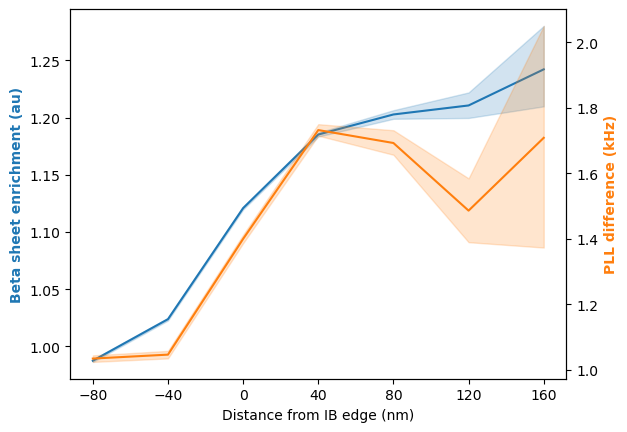

In [4]:
def plot_ib_anatomy(ax=None):
    if ax is None: fig, ax = plt.subplots()
    tax = ax.twinx()

    ddf = df_ibanatomy.groupby('ib_id').filter(lambda x: x.d2e.max() >= 1)#.query('series != "november"')

    sns.lineplot(x=ddf.d2e*40, y=ddf.beta_ratio, ax=ax)
    sns.lineplot(x=ddf.d2e*40, y=ddf.pll, c='C1', ax=tax)

    ax.set_xlabel('Distance from IB edge (nm)')
    ax.set_ylabel('Beta sheet enrichment (au)', c='C0', weight='bold')
    tax.set_ylabel('PLL difference (kHz)', c='C1', weight='bold')

    # Put 1 (beta ratio) and 0 (pll) on the same height and show that reference line
    y1, y2 = ax.get_ylim()
    y3, y4 = tax.get_ylim()
    # tax.set_ylim((y1-1)*y4/(y2-1), y4)
    # ax.axhline(1, ls='--', lw=.5, c='k', alpha=.5)
    ax.xaxis.set_major_locator(plt.MultipleLocator(40))

plot_ib_anatomy()

### Analysis of edge region

<Axes: xlabel='d2e', ylabel='count'>

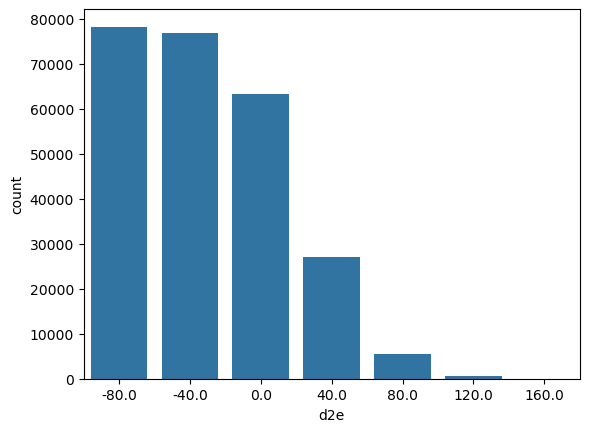

In [5]:
sns.countplot(x=df_ibanatomy.d2e*40)

54.373420007222826


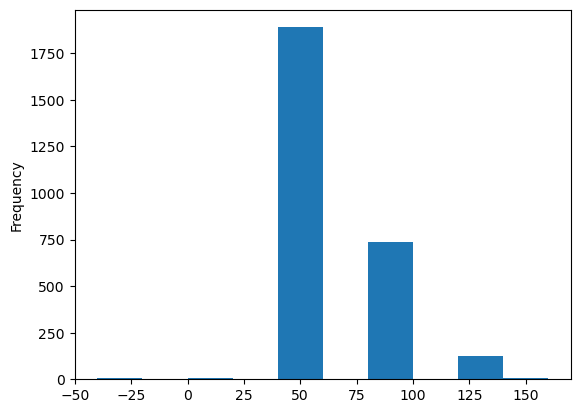

In [6]:
(df_ibanatomy.groupby('ib_id').d2e.max()*40).plot.hist()
mean_ib_radius = df_ibanatomy.groupby('ib_id').d2e.max().mean() * 40
print(mean_ib_radius)

# Correlation heatmap

## Old

alpha_threshold = 0.9999471179270227


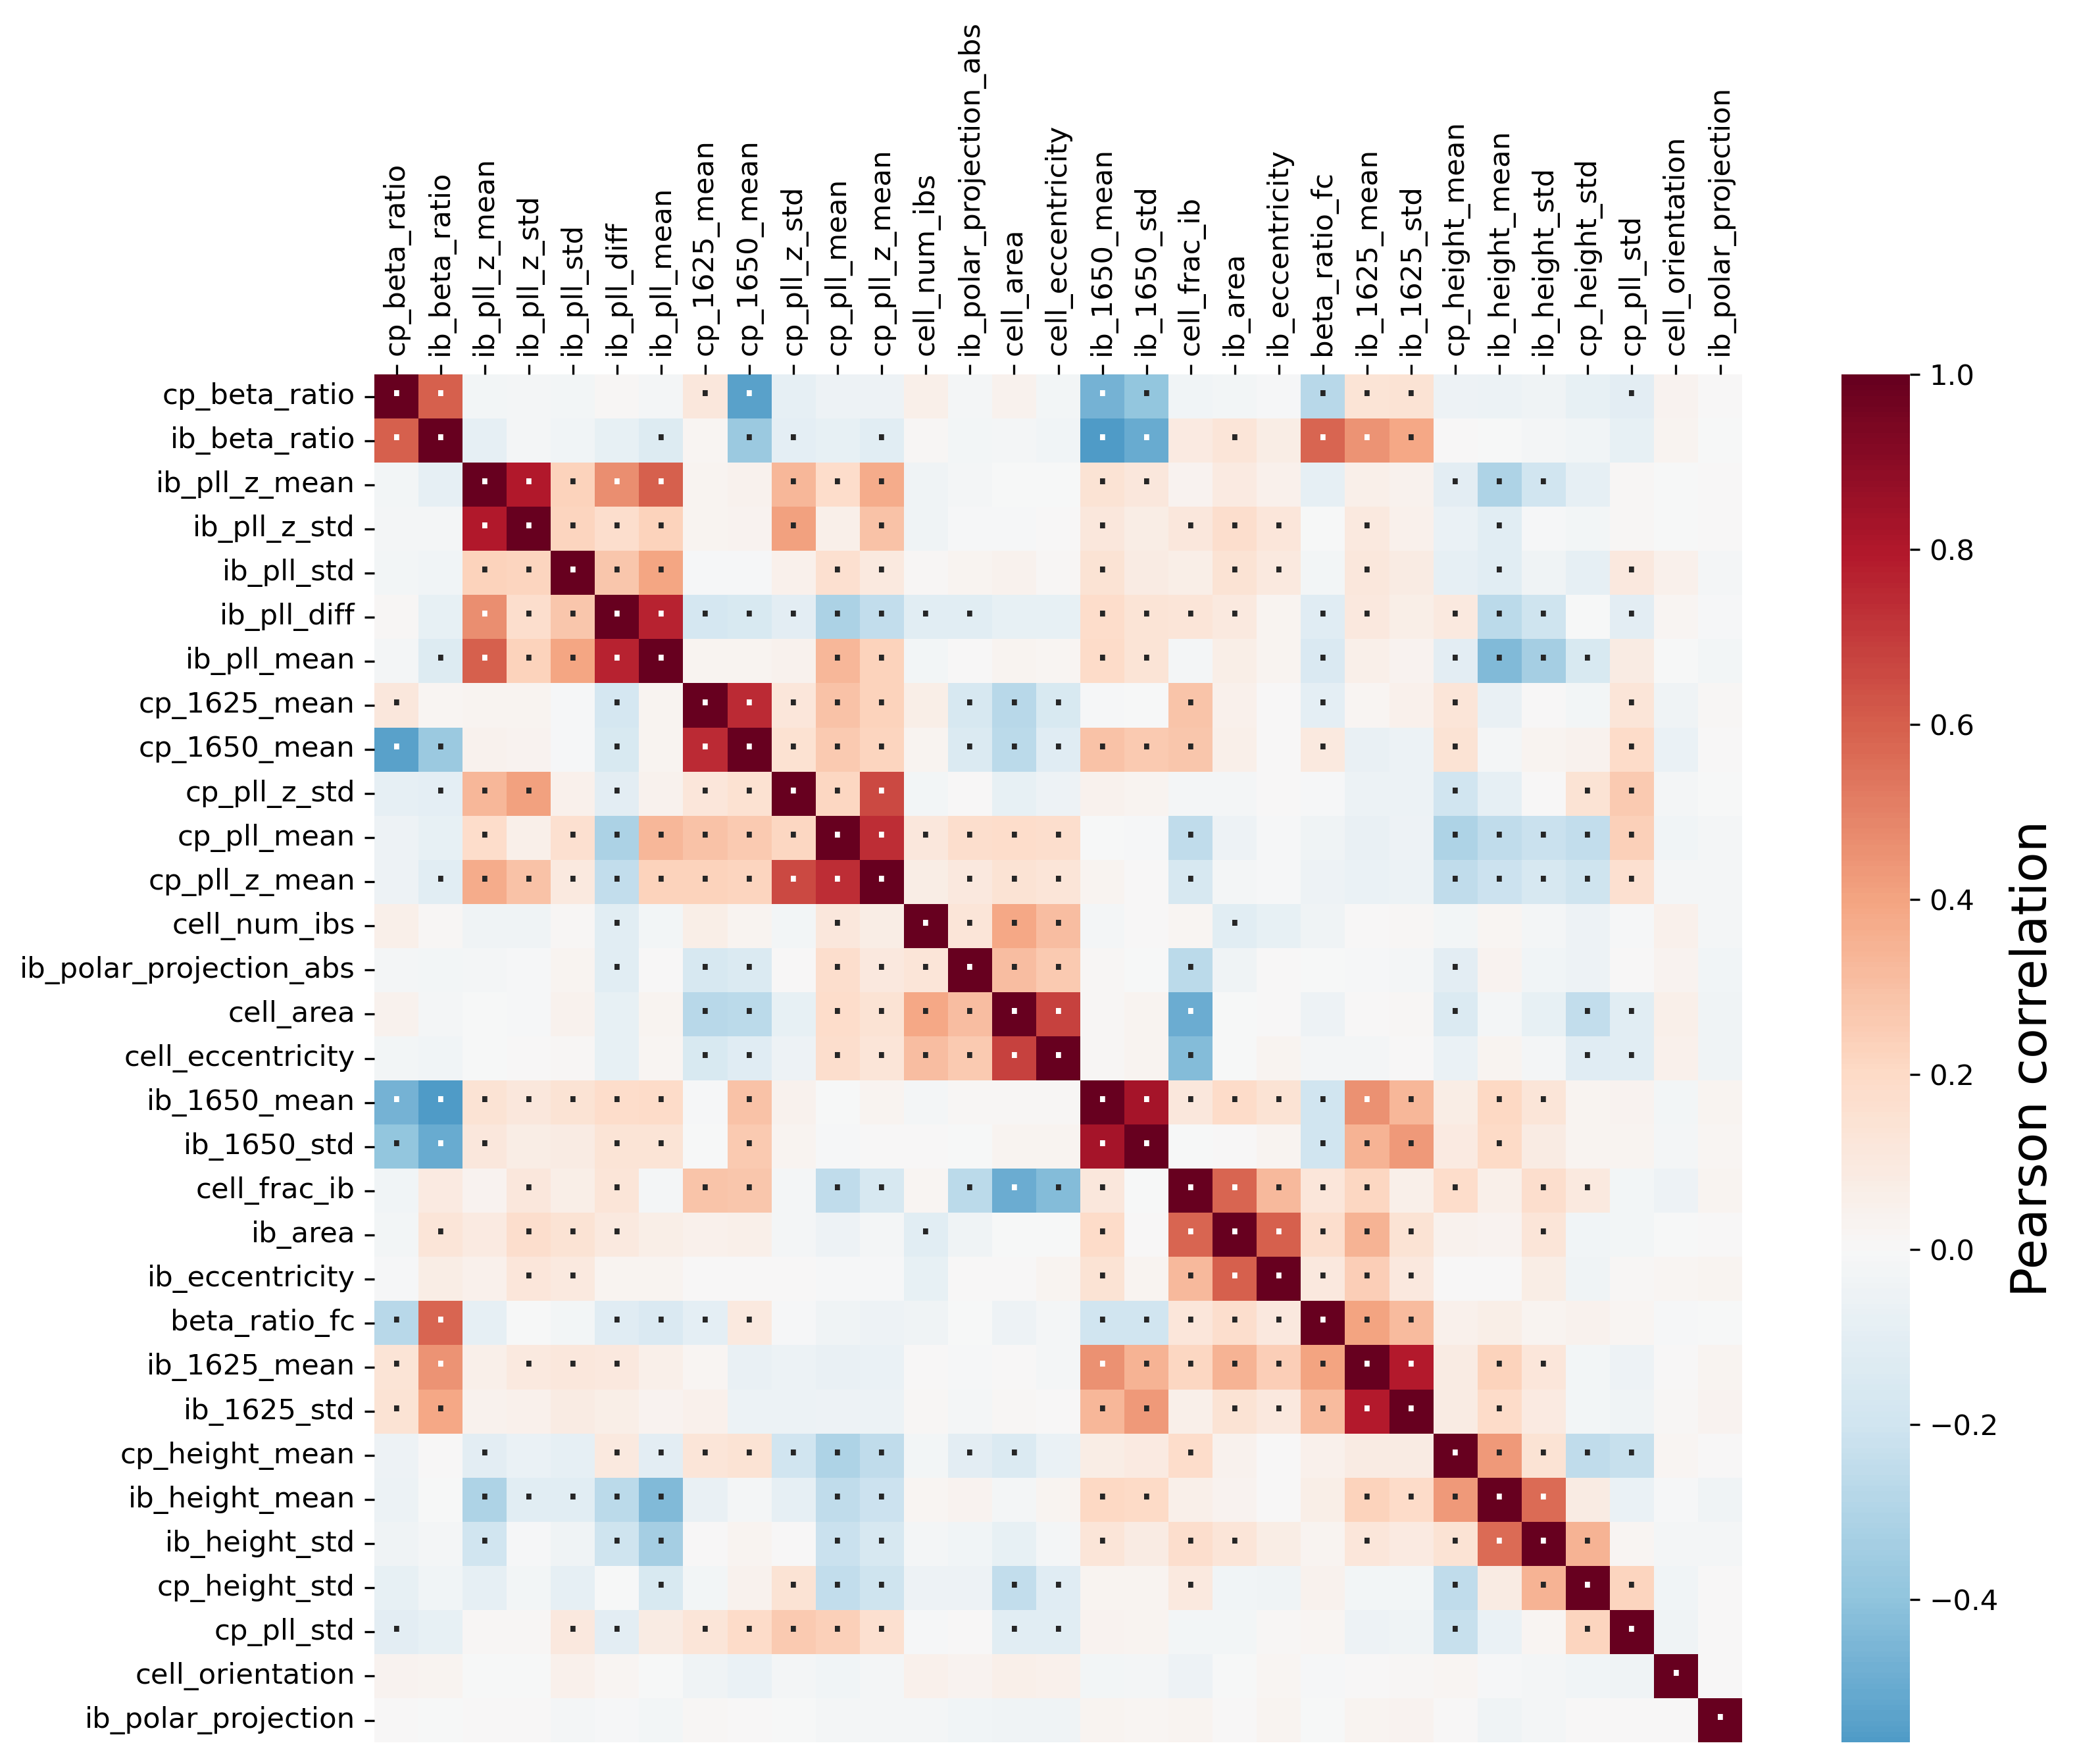

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.stats

OLD_ORDER = None

def plot_correlations(ax=None):
    global OLD_ORDER
    with plt.rc_context({
        'figure.figsize': (13, 9),
        'figure.dpi': 300,
        'font.size': 18,
        'savefig.bbox': 'tight',
        'xtick.labelsize': 'xx-small',
        'ytick.labelsize': 'xx-small'
    }):
        
        if ax is None: fig, ax = plt.subplots()

        # Drop the following columns
        drop_cols = [
            'cell_label', 'ib_area_px', 'cell_area_ib_px', 'centroid-0',
            'centroid-1', 'centroid-0_cell', 'centroid-1_cell', 'ib_num_cells', 
            'ib_centroid_y_frac', 'cell_axis_major_length', 'cell_axis_minor_length',
            'time_post_shock', 'time_post_shock_cell', 'ib_area_log', 'beta_ratio_diff',
            'series',
            'time_post_shock_cell',
            'cantilever_cell',
            'replicate_cell',
            'condition',
            'cantilever',
            'replicate',
            'condition_cell',
            'repeat',
            'spectra_loc',
            'repeat_cell',
            'spectra_loc_cell',
        ]

        # Normalise IB table
        dfsource = (
            ibtable
            .query('experiment == "recovery_timeline"')
            .set_index(['dataset_id', 'ib_label'])
            .drop(drop_cols, axis=1)
            .select_dtypes('number')
            .groupby('dataset_id', group_keys=False)
            .apply(lambda x: (x - x.mean(axis=0)) / x.std(axis=0))
            .dropna()#subset=['cp_1625_mean'])
        )

        # Average by sample
        # dfsource = dfsource.groupby('dataset_id').mean()

        # Calculate correlations
        dfstats = (
            pd.DataFrame([
                {
                    'c1': c1, 
                    'c2': c2,
                    'x': scipy.stats.pearsonr(dfsource[c1], dfsource[c2])
                } 
                for c1 in dfsource.columns 
                for c2 in dfsource.columns
            ])
            .set_index(['c1', 'c2']).unstack()
            .x
        )

        # Reorder columns by hierarchical clustering
        r = dendrogram(linkage(dfstats.map(lambda x: x.statistic), method='average'), no_plot=True)
        reorder = dfstats.columns[r['leaves']]
        OLD_ORDER = reorder
        dfstats = dfstats.loc[OLD_ORDER, OLD_ORDER]

        # Define significance threshold
        n_tests = (len(dfstats)**2 - len(dfstats) / 2)
        alpha_threshold = 1- .05 / n_tests
        print(f'alpha_threshold = {alpha_threshold}')
        def is_significant(pearsonresult):
            ci = pearsonresult.confidence_interval(alpha_threshold)
            return '·' if (0 > ci.high) or (0 < ci.low) else ''
            
        sns.heatmap(
            dfstats.map(lambda x: x.statistic),
            cmap='RdBu_r', center=0, 
            square=True,
            cbar_kws=dict(label='Pearson correlation', location='right', fraction=.05),
            annot=dfstats.map(is_significant), fmt='', 
            ax=ax,
        )
        ax.set_aspect(1)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set(xlabel='', ylabel='')

plot_correlations()

## By pixel

alpha_threshold = 0.9991666666666666


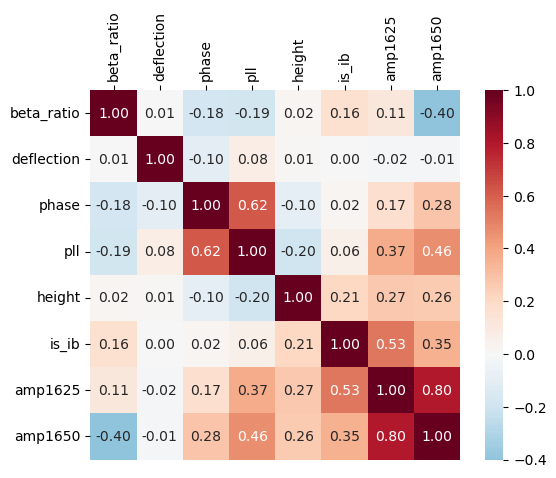

In [8]:
from skimage.morphology import binary_erosion, disk, binary_dilation

def plot_px_correlations(ax=None):
    if ax is None: fig, ax = plt.subplots()

    flatten = lambda x: x.data.flatten()
    zscores = lambda x: (x - np.nanmean(x)) / np.nanstd(x)

    ## Erode cytoplasm masks to remove membrane effects?
    erode = lambda x: x.data #binary_erosion(x, disk(1))

    imdf = pd.concat([
        pd.DataFrame(dict(
            height = zscores(flatten(im.height)),
            pll = zscores(flatten(im.pll)),
            deflection = zscores(flatten(im.deflection)),
            phase = zscores(flatten(im.phase)),
            beta_ratio = zscores(flatten(im.amp1625/im.amp1650)),
            amp1625= zscores(flatten(im.amp1625)),
            amp1650= zscores(flatten(im.amp1650)),
            # is_cp = im.cp_labels.data.flatten().astype(bool).astype(int),
            is_ib = im.ib_labels.data.flatten().astype(bool).astype(int),
            # is_cell = im.cell_labels.data.flatten().astype(bool).astype(int),
            is_epoxy = (~erode(im.cell_labels).flatten().astype(bool)).astype(int),
        )).dropna(how='any').query('is_epoxy!=1').drop(columns='is_epoxy')
        for im in images.values()
        if im.experiment.item() == 'recovery_timeline'
    ])

    dfstats = (
        pd.DataFrame([
            {
                'c1': c1, 
                'c2': c2,
                'rp': scipy.stats.pearsonr(imdf[c1], imdf[c2])
            } 
            for c1 in imdf.columns 
            for c2 in imdf.columns
        ])
        .set_index(['c1', 'c2']).unstack()
        .rp
    )

    r = dendrogram(linkage(dfstats.map(lambda x: x.statistic), method='average'), no_plot=True)
    reorder = dfstats.columns[r['leaves']]
    dfstats = dfstats.loc[reorder, reorder]

    n_tests = (len(dfstats)**2 - len(dfstats) / 2)
    alpha_threshold = 1- .05 / n_tests
    print(f'alpha_threshold = {alpha_threshold}')
    def is_significant(pearsonresult):
        ci = pearsonresult.confidence_interval(alpha_threshold)
        # return pearsonresult.pvalue * n_tests
        return '·' if (0 > ci.high) or (0 < ci.low) else ''


    ax = plt.gca()
    sns.heatmap(
        dfstats.map(lambda x: x.statistic),
        cmap='RdBu_r', center=0, 
        square=True,
        # annot=dfstats.map(is_significant), fmt='', 
        annot=True, fmt='.2f',
        # mask=np.eye(len(dfstats)),
        # mask=np.triu(np.ones_like(dfstats, dtype=bool)),
    )
    ax.set_aspect(1)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(xlabel='', ylabel='')

plot_px_correlations()

* beta ratio 
  * anticorrelated with pll
  * not really correlated with height
* deflection not really correlated with anything
* phase strongly correlated with pll. does that mean pll is being underestimated?
* height
  * anticorrelated with pll
  * correlated with is_ib (this may be an artifact due to my IB segmentation based on amp25, not ratio)
  * conclusion: more material = less stiff but higher iramp -> IBs

Are there regions inside the cell with high beta ratio but low pll?????
If I erode/dilate the cell masks to play with how much membrane is included, the anticorrelation between beta ratio and pll only increases.

Is there a common error in all PPLL defocus areas?


## Corr by image, then averaged

In [9]:
def get_all_correlations():
            # Drop the following columns
        drop_cols = [
            'cell_label', 'ib_area_px', 'cell_area_ib_px', 'centroid-0',
            'centroid-1', 'centroid-0_cell', 'centroid-1_cell', 'ib_num_cells', 
            'ib_centroid_y_frac', 'cell_axis_major_length', 'cell_axis_minor_length',
            'time_post_shock', 'time_post_shock_cell', 'ib_area_log', 'beta_ratio_diff',
            'series',
            'time_post_shock_cell',
            'cantilever_cell',
            'replicate_cell',
            'condition',
            'cantilever',
            'replicate',
            'condition_cell',
            'repeat',
            'spectra_loc',
            'repeat_cell',
            'spectra_loc_cell',
            'ib_pll_z_mean',
            'ib_pll_z_std',
            'cp_pll_z_mean',
            'cp_pll_z_std',
            'ib_1625_std',
            'ib_1650_std',
            'cp_pll_std',
            'ib_pll_std',
        ]

        # Normalise IB table
        dfsource = (
            ibtable
            .query('experiment == "recovery_timeline"')
            .set_index(['dataset_id', 'ib_label'])
            .drop(drop_cols, axis=1)
            .select_dtypes('number')
            .groupby('dataset_id', group_keys=False)
            .apply(lambda x: (x - x.mean(axis=0)) / x.std(axis=0))
            .dropna()#subset=['cp_1625_mean'])
        )
        # print(dfsource.columns)

        def calc_pearson(df):
            return pd.DataFrame([
                {
                    'c1': c1, 
                    'c2': c2,
                    'pearson_r': scipy.stats.pearsonr(df[c1], df[c2]).statistic
                }
                for c1 in df.columns
                for c2 in df.columns
            ]).set_index(['c1', 'c2'])
        
        dfstats = (
            dfsource.groupby('dataset_id')
            .apply(calc_pearson)
            .reset_index()
        )
        return dfstats

dfstats = get_all_correlations()
dfstats

,dataset_id,c1,c2,pearson_r
0,recovery_timeline_april_BA,ib_eccentricity,ib_eccentricity,1.000000
1,recovery_timeline_april_BA,ib_eccentricity,ib_1625_mean,0.222309
2,recovery_timeline_april_BA,ib_eccentricity,ib_1650_mean,0.203863
3,recovery_timeline_april_BA,ib_eccentricity,ib_pll_mean,0.039840
4,recovery_timeline_april_BA,ib_eccentricity,ib_height_mean,0.192885
...,...,...,...,...
17981,recovery_timeline_november_R5C,ib_pll_diff,cp_1650_mean,-0.292737
17982,recovery_timeline_november_R5C,ib_pll_diff,cp_pll_mean,-0.439612
17983,recovery_timeline_november_R5C,ib_pll_diff,cp_beta_ratio,-0.052326
17984,recovery_timeline_november_R5C,ib_pll_diff,beta_ratio_fc,-0.076213


In [10]:
from functools import cache

@cache
def process_corrs():
    df = get_all_correlations()
    num_tests = len(dfstats.c1.unique())**2 #* 3
    print('num tests:', num_tests)
    alpha = .05 / num_tests
    print('alpha:', alpha)

    rename_map = {
        'beta_ratio_fc' :          'beta_enrichment',
        'cell_area' :              'cell_area',
        'cell_eccentricity' :      'cell_eccentricity',
        'cell_frac_ib' :           'cell_fraction_ib_area',
        'cell_num_ibs' :           'cell_num_ibs',
        'cell_orientation' :       'cell_orientation',
        'cp_1625_mean' :           'iramp_1625_cytoplasm',
        'cp_1650_mean' :           'iramp_1650_cytoplasm',
        'cp_beta_ratio' :          'beta_ratio_cytoplasm',
        'cp_height_mean' :         'height_cytoplasm',
        'cp_height_std' :          'roughness_cytoplasm',
        'cp_pll_mean' :            'pll_cytoplasm',
        'ib_1625_mean' :           'iramp_1625_ib',
        'ib_1650_mean' :           'iramp_1650_ib',
        'ib_area' :                'ib_area',
        'ib_beta_ratio' :          'beta_ratio_ib',
        'ib_eccentricity' :        'ib_eccentricity',
        'ib_height_mean' :         'height_ib',
        'ib_height_std' :          'roughness_ib',
        'ib_pll_diff' :            'pll_difference',
        'ib_pll_mean' :            'pll_ib',
        'ib_polar_projection' :    'polar_projection_ib',
        'ib_polar_projection_abs' : 'polar_proximity_ib'
    }

    def bootstrap_sig(data, alpha=.05):
        if data.mean() > .9999: return True
        br = scipy.stats.bootstrap(
            data=[data],
            statistic=np.mean,
            confidence_level=1-alpha
        )
        ci = br.confidence_interval
        return np.sign(ci.low) == np.sign(ci.high)
    
    return df.assign(
        c1 = lambda x: x.c1.map(rename_map),
        c2 = lambda x: x.c2.map(rename_map)
    ).groupby(['c1','c2']).pearson_r.aggregate(
        pearson_r=lambda x: x.mean(),
        # shapiro=lambda x: scipy.stats.shapiro(x).pvalue,
        # ttest=lambda x: scipy.stats.ttest_1samp(x, 0).pvalue,
        # mannwhitney=lambda x: scipy.stats.mannwhitneyu(x, [0]).pvalue,
        bootstrap_sig=lambda x: bootstrap_sig(x, alpha)
    )

process_corrs().pearson_r.unstack()

num tests: 529
alpha: 9.45179584120983e-05


c2,beta_enrichment,beta_ratio_cytoplasm,beta_ratio_ib,cell_area,cell_eccentricity,cell_fraction_ib_area,cell_num_ibs,cell_orientation,height_cytoplasm,height_ib,...,iramp_1625_ib,iramp_1650_cytoplasm,iramp_1650_ib,pll_cytoplasm,pll_difference,pll_ib,polar_projection_ib,polar_proximity_ib,roughness_cytoplasm,roughness_ib
c1,,,,,,,,,,,,,,,,,,,,,
beta_enrichment,1.000000,-0.213218,0.611083,-0.034700,-0.019409,0.074602,-0.076063,-0.026278,-0.022437,0.056879,...,0.424662,0.030146,-0.205152,-0.005638,-0.100247,-0.105075,0.003391,-0.008133,-0.001288,0.042868
beta_ratio_cytoplasm,-0.213218,1.000000,0.608882,0.038523,-0.045864,-0.046648,0.038387,-0.035279,-0.053307,-0.060724,...,0.107184,-0.542427,-0.499269,-0.029858,0.004575,-0.021356,-0.005069,-0.000376,-0.082931,-0.050159
beta_ratio_ib,0.611083,0.608882,1.000000,0.005150,-0.042847,0.045714,-0.015793,-0.033541,-0.045465,-0.012136,...,0.431644,-0.400053,-0.568227,-0.042059,-0.069014,-0.101407,-0.005955,-0.015301,-0.057979,-0.014912
cell_area,-0.034700,0.038523,0.005150,1.000000,0.659214,-0.473456,0.419517,0.032123,-0.138560,-0.015682,...,0.020446,-0.223456,0.000124,0.174823,-0.075592,0.029157,-0.008980,0.285555,-0.245066,-0.050190
cell_eccentricity,-0.019409,-0.045864,-0.042847,0.659214,1.000000,-0.432333,0.290208,0.070566,-0.093496,-0.005278,...,-0.037791,-0.123442,0.011385,0.127819,-0.045846,0.039905,-0.036530,0.207162,-0.146758,-0.022598
cell_fraction_ib_area,0.074602,-0.046648,0.045714,-0.473456,-0.432333,1.000000,0.046524,-0.018464,0.224669,0.079037,...,0.218778,0.264747,0.160626,-0.266190,0.121540,-0.031880,0.007877,-0.262519,0.170102,0.170651
cell_num_ibs,-0.076063,0.038387,-0.015793,0.419517,0.290208,0.046524,1.000000,0.067263,0.001868,0.021956,...,0.004406,0.023978,0.011606,0.051307,-0.064235,-0.018486,-0.019508,0.087694,-0.051989,0.008667
cell_orientation,-0.026278,-0.035279,-0.033541,0.032123,0.070566,-0.018464,0.067263,1.000000,0.006973,-0.018385,...,-0.017351,0.008344,0.025895,-0.018313,0.021968,0.017191,-0.012281,0.035903,-0.001939,0.012388
height_cytoplasm,-0.022437,-0.053307,-0.045465,-0.138560,-0.093496,0.224669,0.001868,0.006973,1.000000,0.428047,...,0.068163,0.166687,0.099380,-0.369515,0.107338,-0.138494,-0.001649,-0.113870,-0.146163,0.123413


['beta_ratio_cytoplasm' 'beta_ratio_ib' 'roughness_cytoplasm'
 'height_cytoplasm' 'height_ib' 'roughness_ib' 'cell_fraction_ib_area'
 'ib_area' 'ib_eccentricity' 'beta_enrichment' 'iramp_1625_ib'
 'iramp_1650_ib' 'iramp_1625_cytoplasm' 'iramp_1650_cytoplasm'
 'pll_difference' 'pll_ib' 'cell_orientation' 'polar_projection_ib'
 'pll_cytoplasm' 'polar_proximity_ib' 'cell_num_ibs' 'cell_area'
 'cell_eccentricity']


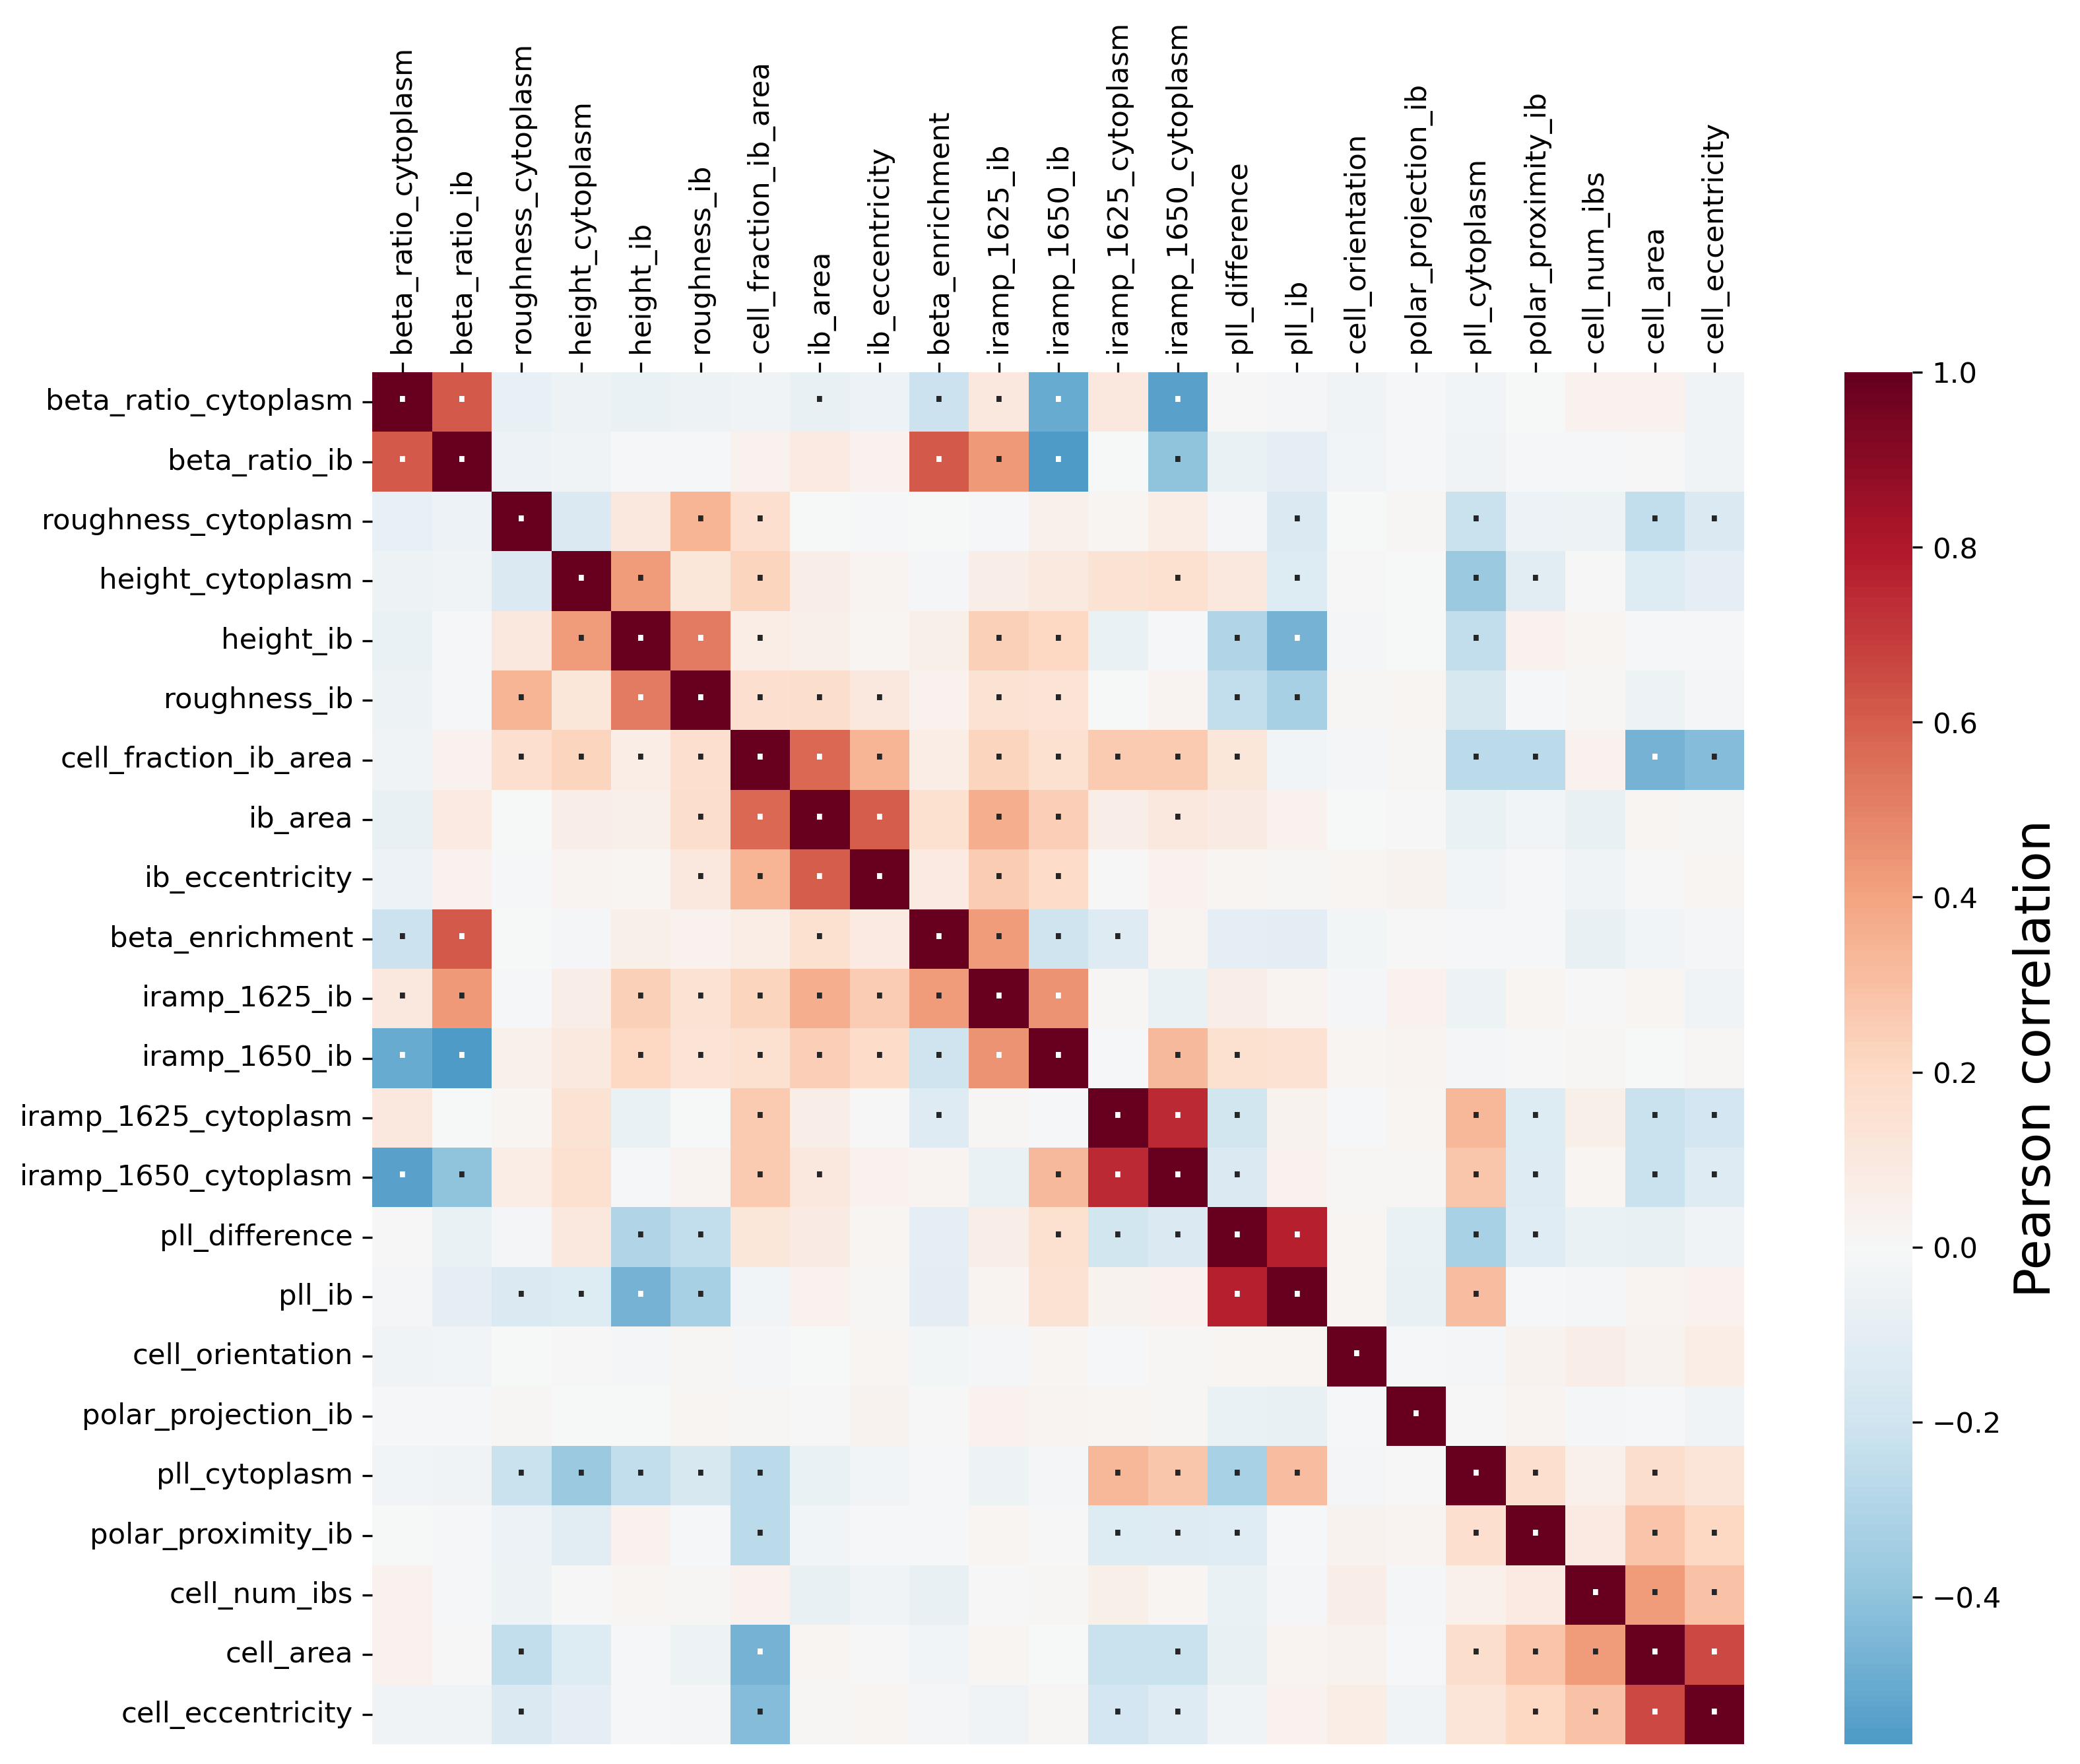

In [11]:
def plotcorr_smart_avg(ax=None):
    with plt.rc_context({
        'figure.figsize': (13, 9),
        'figure.dpi': 300,
        'font.size': 18,
        'savefig.bbox': 'tight',
        'xtick.labelsize': 'xx-small',
        'ytick.labelsize': 'xx-small'
    }):
        
        if ax is None: fig, ax = plt.subplots()

        # dfstats = get_all_correlations()
        dfstats = process_corrs()

        dfcorrs = dfstats.pearson_r.unstack()
        dfsigs  = dfstats.bootstrap_sig.unstack().map(lambda x: '·' if x else '')

        # Reorder columns by hierarchical clustering
        r = dendrogram(linkage(dfcorrs, method='average'), no_plot=True)
        # print(r['leaves'])
        reorder = dfcorrs.columns[r['leaves']]
        dfcorrs = dfcorrs.loc[reorder, reorder]
        dfsigs = dfsigs.loc[reorder, reorder]
        print(reorder.values)
        
        sns.heatmap(
            dfcorrs,
            cmap='RdBu_r', center=0, 
            square=True,
            cbar_kws=dict(label='Pearson correlation', location='right', fraction=.05),
            annot=dfsigs, fmt='',
            ax=ax,
        )
        ax.set_aspect(1)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set(xlabel='', ylabel='')


plotcorr_smart_avg()

# Closeup

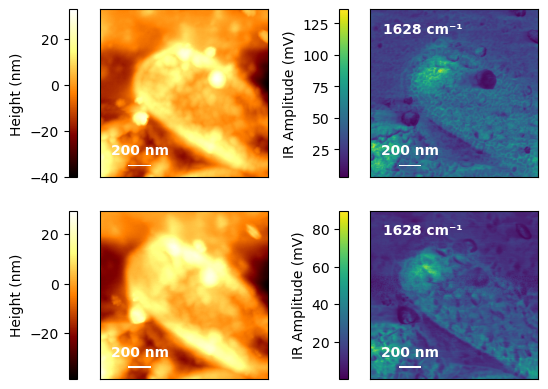

In [12]:
path = '../../../Experiments/2022-06 June/2022-06-15/2022-06-13 nexttip 1A hs1/'
doc_nt = aptwrapper.read(path + 'nexttip.axz')
doc_bruker = aptwrapper.read(path + 'tb005c.axz')

fig, ax = plt.subplots(2,2)
aptwrapper.plot_map(doc_nt.HeightMaps['Height 5'], ax[0,0])
aptwrapper.plot_map(doc_nt.HeightMaps['IR Amplitude 5'], ax[0,1])
aptwrapper.plot_map(doc_bruker.HeightMaps['Height 6'], ax[1,0])
aptwrapper.plot_map(doc_bruker.HeightMaps['IR Amplitude 6'], ax[1,1])

pixel width of closeup: 2.9296875 nm
resolution compared to other datasets: 13.333333333333334
imwidth 1.4970703125


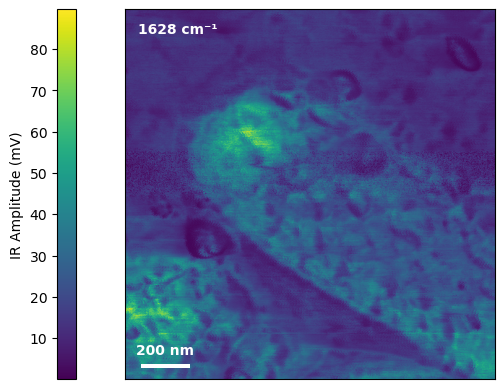

In [13]:
def plot_closeup(ax=None):
    if ax is None: fig, ax = plt.subplots()
    path = '../../../Experiments/2022-06 June/2022-06-15/2022-06-13 nexttip 1A hs1/'
    doc_nt = aptwrapper.read(path + 'nexttip.axz')
    doc_bruker = aptwrapper.read(path + 'tb005c.axz')
    irmap = doc_bruker.HeightMaps['IR Amplitude 6']
    aptwrapper.plot_map(irmap, ax)

    res=irmap.X.diff('x').mean().item()
    print('pixel width of closeup:',res*1e3,'nm' )
    print('resolution compared to other datasets:', 20/512/res)
    print('imwidth', irmap.X.max().item() - irmap.X.min().item())

plot_closeup()

# Composite

pixel width of closeup: 2.9296875 nm
resolution compared to other datasets: 13.333333333333334
imwidth 1.4970703125
['beta_ratio_cytoplasm' 'beta_ratio_ib' 'roughness_cytoplasm'
 'height_cytoplasm' 'height_ib' 'roughness_ib' 'cell_fraction_ib_area'
 'ib_area' 'ib_eccentricity' 'beta_enrichment' 'iramp_1625_ib'
 'iramp_1650_ib' 'iramp_1625_cytoplasm' 'iramp_1650_cytoplasm'
 'pll_difference' 'pll_ib' 'cell_orientation' 'polar_projection_ib'
 'pll_cytoplasm' 'polar_proximity_ib' 'cell_num_ibs' 'cell_area'
 'cell_eccentricity']


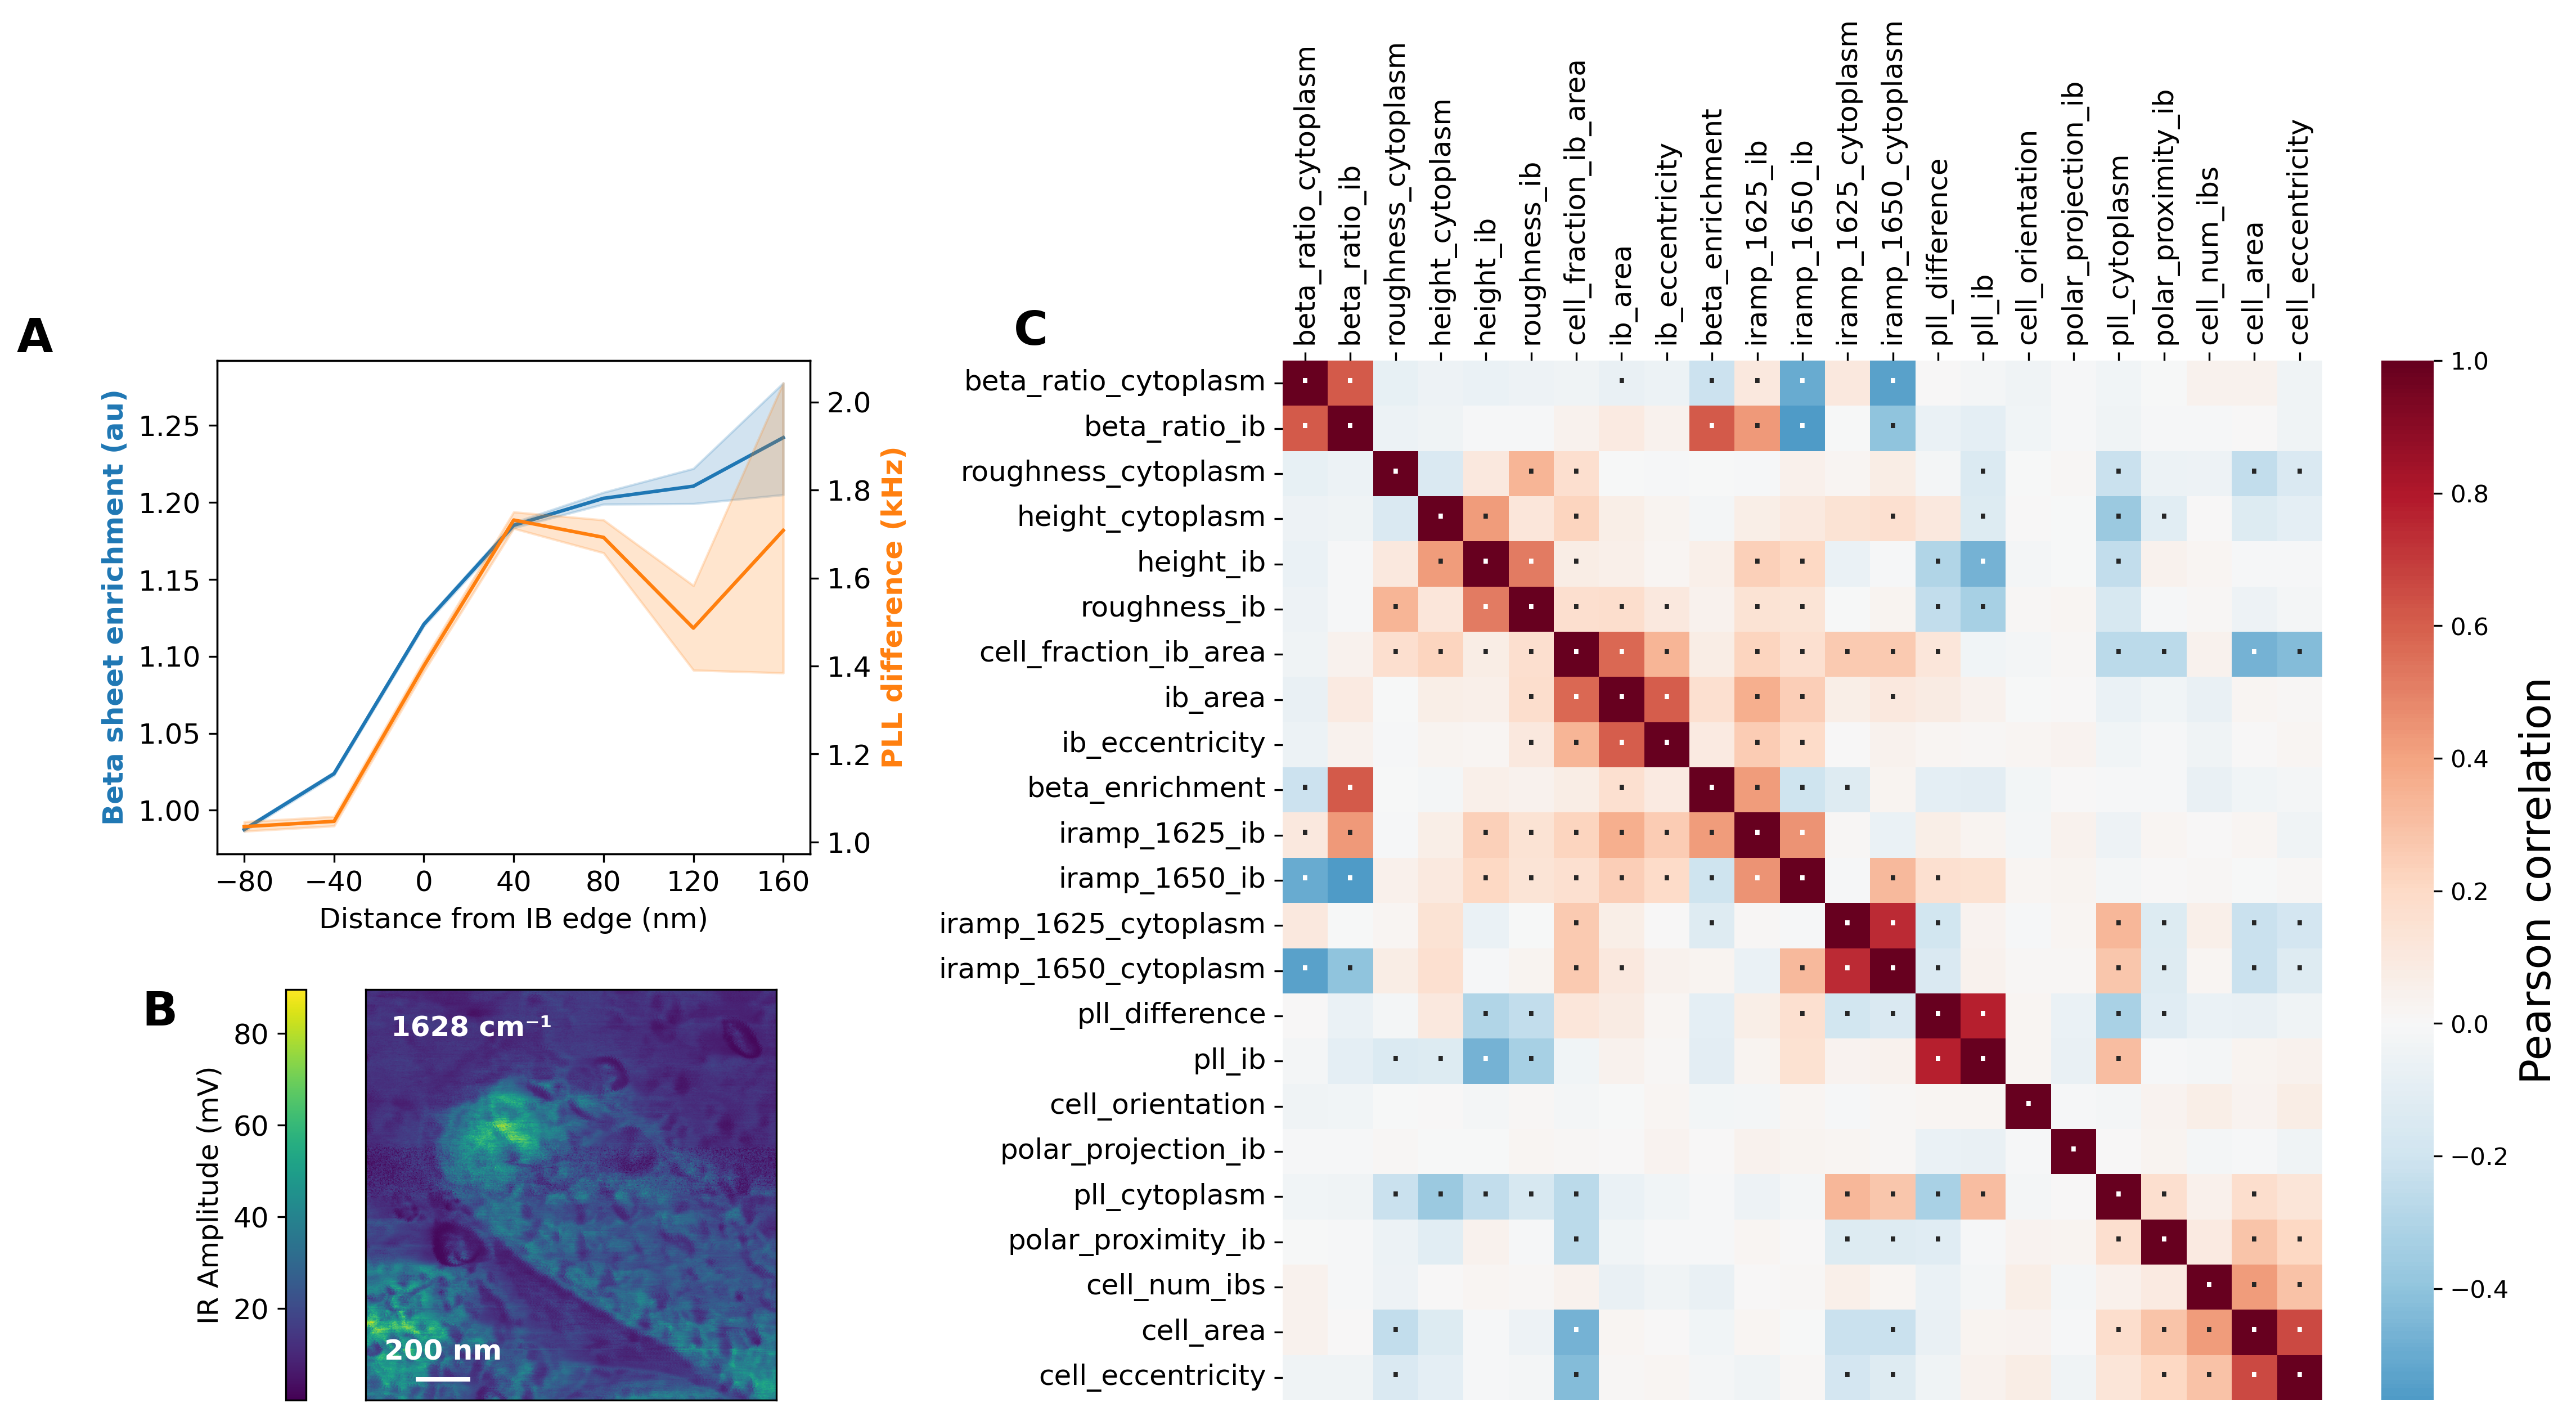

In [14]:
from matplotlib.gridspec import GridSpecFromSubplotSpec

with plt.rc_context({
    'figure.figsize': (17,8),
    'figure.dpi': 300,
    'font.size': 12,
    'savefig.bbox': 'tight',
    'legend.loc': 'upper right',
}):
    
    fig, ax = plt.subplot_mosaic(
        mosaic=[
            ['a', 'c'],
            ['b', 'c']
        ],
        gridspec_kw={
            'height_ratios': [1.2, 1],
            'width_ratios': [1, 2],
            'hspace': .3,
            'wspace': .5
        },
    )

    # ax['b'].axis('off')
    # gs = GridSpecFromSubplotSpec(
    #     1, 2, ax['b'], wspace=0, width_ratios=[1, .1]
    # )
    # axb = fig.add_subplot(gs[0])

    plot_ib_anatomy(ax['a'])
    plot_closeup(ax['b'])
    plotcorr_smart_avg(ax['c'])

    kwargs = dict(
        ha='right',
        va='top',
        xycoords=('axes points',
        'axes fraction'),
        fontsize=20,
        fontweight='bold')
    
    ax['a'].annotate('A', (-70,1.09), **kwargs)
    ax['b'].annotate('B', (-80, 1), **kwargs)
    ax['c'].annotate('C', (-100,1.05), **kwargs)

    import os
    output_directory = "../figures"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    # fig.suptitle('Figure 6', y=1.2, x=.1, ha='left', fontsize=24, weight='bold')
    plt.savefig('../figures/figure_6.jpg', bbox_inches='tight', dpi=600)
    plt.savefig('../figures/figure_6.pdf', bbox_inches='tight')
    fig.suptitle('')